In [311]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline  

In [312]:
# Set up the board for Connect 4
rows = 6
columns = 7
M = np.zeros((rows, columns))

In [313]:
# Define the set of actions, agent states, and the Q table
A = np.array([0, 1, 2, 3, 4, 5, 6])
S = []
for i in range(0, rows * columns):
    S.append(i)
S = np.array(S)

# Initialize the Q tables
Q1 = np.zeros((S.shape[0], A.shape[0]))
Q2 = np.zeros((S.shape[0], A.shape[0]))


In [314]:
def create_board_states(num_rows, num_columns):
    """
    Create all possible board states for a Connect 4 game given the number of rows and columns.
    
    Args:
        num_rows (int): Number of rows on the game board.
        num_columns (int): Number of columns on the game board.
        
    Returns:
        board_states (list): List containing all (x, y) coordinates of the board states in row-major order.
    """
    board_states = []
    
    # Generate board states by iterating over each (x, y) coordinate
    for y in range(num_rows):
        for x in range(num_columns):
            board_states.append((x, y))
    
    return board_states

board_state = create_board_states(rows, columns)

In [315]:
def get_coordinates_from_agent_state(agent_state, board_states):
    """
    Get the coordinates (x, y) corresponding to the given agent state.
    """
    coordinates = board_states[agent_state]
    return coordinates

def get_agent_state_from_coordinates(x, y, board_states):
    """
    Get the agent state corresponding to the given coordinates (x, y).
    """
    agent_state = board_states.index((x, y))
    return agent_state


In [316]:
def compute_new_state(action, board, board_states):
    """
    Compute the new state resulting from an action and the current board state.
    """
    row = 0
    col = action

    # Check if the chosen column is already filled
    if board[row, col] != 0:
        return -1, col, row

    # Simulate gravity: the token falls to the lowest available position in the chosen column
    while row < board.shape[0] and board[row, col] == 0:
        row += 1

    # Adjust the row if the token falls onto an occupied cell
    if row > 0:
        row -= 1

    # Compute the new agent state based on the updated coordinates
    new_agent_state = get_agent_state_from_coordinates(col, row, board_states)
    return new_agent_state, col, row


In [317]:
def check_for_winner(board, player_id):
    """
    Check if a board represents a winning game for the given player.
    """
    num_columns = board.shape[1]
    num_rows = board.shape[0]

    # Check horizontal locations for win
    for col in range(num_columns - 3):
        for row in range(num_rows):
            if (
                board[row][col] == player_id
                and board[row][col + 1] == player_id
                and board[row][col + 2] == player_id
                and board[row][col + 3] == player_id
            ):
                return True

    # Check vertical locations for win
    for col in range(num_columns):
        for row in range(num_rows - 3):
            if (
                board[row][col] == player_id
                and board[row + 1][col] == player_id
                and board[row + 2][col] == player_id
                and board[row + 3][col] == player_id
            ):
                return True

    # Check positively sloped diagonals
    for col in range(num_columns - 3):
        for row in range(num_rows - 3):
            if (
                board[row][col] == player_id
                and board[row + 1][col + 1] == player_id
                and board[row + 2][col + 2] == player_id
                and board[row + 3][col + 3] == player_id
            ):
                return True

    # Check negatively sloped diagonals
    for col in range(num_columns - 3):
        for row in range(3, num_rows):
            if (
                board[row][col] == player_id
                and board[row - 1][col + 1] == player_id
                and board[row - 2][col + 2] == player_id
                and board[row - 3][col + 3] == player_id
            ):
                return True

    return False

def check_if_winning_game(board, player_id):
    """
    Check if the given player has won the game.
    """
    winner_id = check_for_winner(board, player_id)
    return winner_id


In [318]:
def step(action, agent_state, board, player_id, board_state):
    """
    Take an action in the game.
    """
    done = False
    reward = 0

    new_agent_state, x_new, y_new = compute_new_state(action, board, board_state)

    if new_agent_state == -1:  # Check if it's possible to move to the new state
        done = True
        reward = -1
        return agent_state, reward, done

    board[y_new, x_new] = player_id  # Place the token in the new empty slot

    win = check_if_winning_game(board, player_id)  # Check if the player has won the game

    if win:
        reward = 1
        done = True

    return new_agent_state, reward, done


In [319]:
M = np.zeros((rows, columns))
state = 0  
done = False
image_list = []  
step_counter = 0
idplayer = 1

while not done:  # Move until we reach the end of the game
    action = random.choice(A)  # Choose a random action
    new_state, reward, done = step(action, state, M, idplayer, board_state)  # Move according to the action
    state = new_state  # Update the state
    step_counter += 1 
    idplayer = (idplayer % 2) + 1  # Cycle between player IDs 1 and 2

    if idplayer == 1:
        idplayer = 2

In [320]:
def choose_action_from_policy(action_space, epsilon, Q_values, state):
    """
    Choose an action from the epsilon-greedy policy based on the Q-values.
    """
    if random.random() < epsilon:
        action = random.choice(action_space)
    else:
        action = np.argmax(Q_values[state, :])

    return action


In [321]:
def update_qvalues(Q, state, action, new_state, reward, alpha, gamma):
    """
    Update the Q-value for a state-action pair using the Q-learning algorithm.
    """
    first_term = (1 - alpha) * Q[state, action]
    second_term = gamma * np.max(Q[new_state, :])
    third_term = alpha * (reward + second_term)
    res = first_term + third_term
    Q[state, action] = res


In [322]:
def one_game_learning(actions, Q1, Q2, board, epsilon1, epsilon2, alpha, gamma, list_images, t):    
    state = 0
    done = False
    total_rewards = 0
    while not done:  # Move until a player loses
        
        # Player 1 plays first
        action1 = choose_action_from_policy(actions, epsilon1, Q1, state)  # Choose an action
        new_state1, reward1, end1 = step(action1, state, board, 1, board_state)  # Move according to the action
        
        # Update Q1
        update_qvalues(Q1, state, action1, new_state1, reward1, alpha, gamma)
        total_rewards += Q1[state, action1]
        # Player 1 has won
        if end1 and reward1 > 0:
            return 1, total_rewards
        
        # Bad move from Player 1, so Player 2 has won
        if end1 and reward1 == -1:
            return 2, total_rewards
        
        # Player 2 plays
        action2 = choose_action_from_policy(actions, epsilon2, Q2, new_state1)  # Choose an action
        new_state2, reward2, end2 = step(action2, new_state1, board, 2, board_state)  # Move according to the action
        
        # Update Q2
        update_qvalues(Q2, new_state1, action2, new_state2, reward2, alpha, gamma)
        
        # Player 2 has won
        if end2 and reward2 > 0:
            return 2, total_rewards
        
        # Bad move from Player 2, so Player 1 has won
        if end2 and reward2 == -1:
            return 1, total_rewards
        
        state = new_state2
    
    return 0, total_rewards

Percentage of winning games for player one: 59.650000000000006


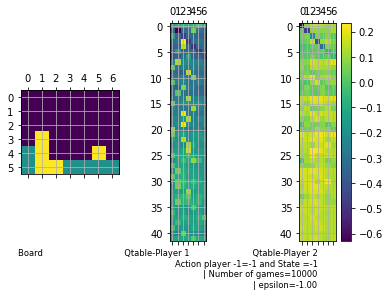

In [323]:
""" Run 10,000 games for the Q-table"""
# Set up the board for Connect 4
M = np.zeros((rows, columns))

fig, axarr = plt.subplots(1, 3)
list_images = []  
q_values_history = []

axarr[0].grid(which='both')
axarr[1].grid(which='both')
axarr[2].grid(which='both')

# Q-learning running
Q1 = np.zeros((S.shape[0], A.shape[0]))
Q2 = np.zeros((S.shape[0], A.shape[0]))
board_state = create_board_states(rows, columns)
rewards = 0
# Define hyperparameters
alpha = 0.01  
gamma = 0.9  
epsilon1 = 0.3  # Probability of exploration for Player 1
epsilon2 = 1  # Probability of exploration for Player 2 (random player)
num_games = 10000 

stats_num_player_one_wins = 0

for t in range(num_games):
    M = np.zeros((rows, columns))
    player_one_wins, rewards = one_game_learning(A, Q1, Q2, M, epsilon1, epsilon2, alpha, gamma, list_images, t)
    
    if player_one_wins == 1:
        stats_num_player_one_wins += 1
    
stats_num_player_one_wins /= float(num_games)
stats_num_player_one_wins *= 100

print("Percentage of winning games for player one: " + str(stats_num_player_one_wins))

ttl = plt.text(3, 43, 
    "Board                               Qtable-Player 1                        Qtable-Player 2" +
    "\nAction player " + str(-1) + "=" + str(-1) + " and State =" + str(-1) + "\n" +
    "| Number of games=" + str(num_games) + "\n" + "| epsilon=" + "{:.2f}".format(-1),                       
    horizontalalignment='right', verticalalignment='top', fontsize="small")
im1 = axarr[0].matshow(M, animated=True)
im2 = axarr[1].matshow(Q1, animated=True)
im3 = axarr[2].matshow(Q2, animated=True)
list_images.append([im1, im2, im3, ttl])
fig.colorbar(im3, ax=axarr[2])



In [324]:
list_images = []
alpha = 0.01
gamma = 0.9
epsilon1 = 0
epsilon2 = 1
num_games = 10000
total_rewards = 0
reward_history = []

stats_num_player_one_wins = 0

for t in range(num_games):
    M = np.zeros((rows, columns))
    player_one_wins, total_rewards = one_game_learning(A, Q1.copy(), Q2.copy(), M, epsilon1, epsilon2, alpha, gamma, list_images, t)
    reward_history.append(total_rewards)
    if player_one_wins == 1:
        stats_num_player_one_wins += 1

stats_num_player_one_wins /= float(num_games)
stats_num_player_one_wins *= 100

print("Percentage of winning games for player one: " + str(stats_num_player_one_wins))


Percentage of winning games for player one: 62.019999999999996


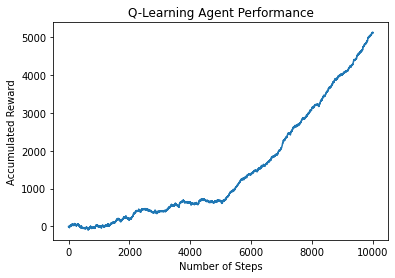

In [327]:
# Plotting the change in Q-value after each episode
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.title('Q-Learning Agent Performance')
plt.show()